<a href="https://colab.research.google.com/github/afortuny/DeepLearningFastAI/blob/main/DL_Classifying_Pets_with_Fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning on Pets Classification


In the following notebook, we start an exciting on hands journey following the FastAI course. I do my best to ensure these code will run on your session, please make sure you are using the same fastai version 2.5.3:

In [1]:
 !curl -s https://course19.fast.ai/setup/colab | bash

Updating fastai...
Done.




Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [4]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [5]:
from fastai.vision.all import *
help(untar_data)

Help on function untar_data in module fastai.data.external:

untar_data(url, archive=None, data=None, c_key='data', force_download=False)
    Download `url` to `fname` if `dest` doesn't exist, and extract to folder `dest`



In [6]:
path = untar_data(URLs.PETS); path

Path('/root/.fastai/data/oxford-iiit-pet')

In [7]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [8]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly to get the labels from the filenames using a regular expression

In [9]:
fnames = get_image_files(path_img)
fnames[:5]

(#5) [Path('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_170.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_193.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_71.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_87.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_setter_101.jpg')]

Set the random seed to two to guarantee that the same validation set is every time. This will give you consistent results. The pattern is quite general, keep in mind that if you are using a folder with files other than jpeg, jpg, you may have to make the pick patter more exhaustive. The current data set contain jpg and jpeg files only.


In [10]:
np.random.seed(2)
pat = r'^(.*)_\d+.*$'

In the following we import data loaders object to read each image using its path, file name, the parsing pattern, the batch size, the validation data set 20%, resizing all images to 224 and normalizing the pixel values. Resizing is required so all images have same size and normallizing helps for learning

In [11]:


from fastai.vision.data import ImageDataLoaders
data = ImageDataLoaders.from_name_re(path_img, fnames, pat,bs=bs,valid_pct=0.2,item_tfms=Resize(224),batch_tfms=Normalize.from_stats(*imagenet_stats))




Show batch is very useful to get a glimps of the data

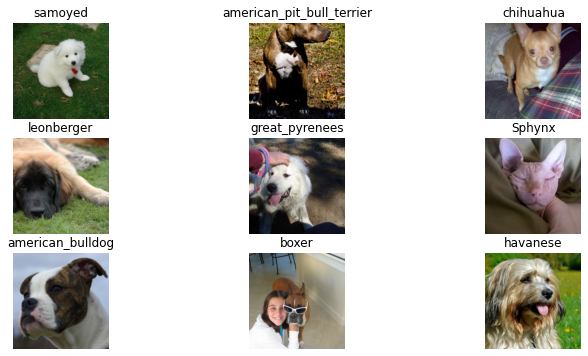

In [12]:
data.show_batch(figsize=(12,6))

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier.We are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We use pretrained resnet34, use error rate as matric on the previously created data object.

In [13]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [14]:
#learn.model

In [15]:
learn.fit_one_cycle(4) # here we are fitting the model on 4 epochs 

epoch,train_loss,valid_loss,error_rate,time
0,1.906429,0.363853,0.109608,01:16
1,0.679971,0.266542,0.089310,01:11
2,0.390919,0.233845,0.075101,01:11
3,0.269428,0.231000,0.076455,01:12


In [16]:
learn.save('stage-1') #we can save the model for inference

Path('/root/.fastai/data/oxford-iiit-pet/images/models/stage-1.pth')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

The plot top losses function have a bug and I am using this one for the analysis

In [18]:
def plot_top_losses_fix(interp, k, largest=True, **kwargs):
        losses,idx = interp.top_losses(k, largest)
        if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
        if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
        else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
        x,y,its = interp.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
        x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            #plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), L(self.preds).itemgot(idx), losses,  **kwargs)
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses,  **kwargs)
        #TODO: figure out if this is needed
        #its None means that a batch knows how to show itself as a whole, so we pass x, x1
        #else: show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)

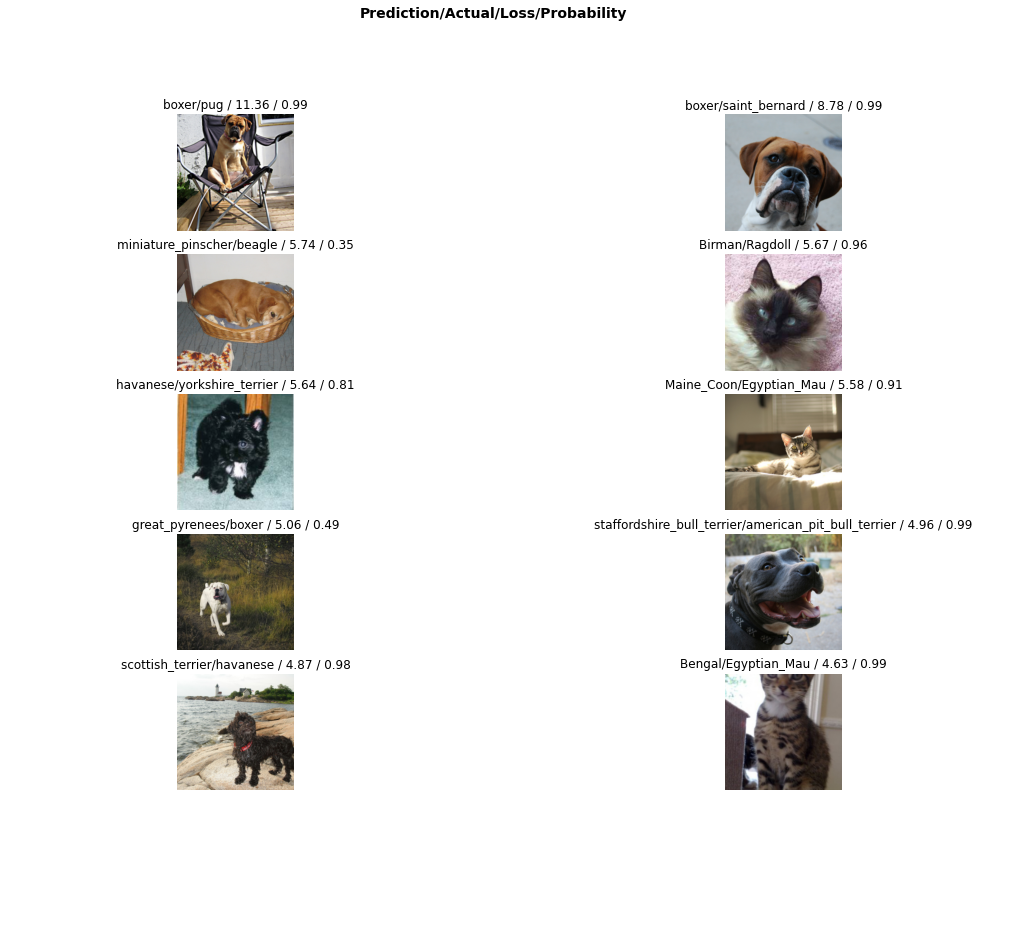

In [19]:
plot_top_losses_fix(interp, 10, nrows=6,figsize=(18,15)) #those are the examples where the error is the largest

But note from the confusion matrix that the model is mostly classifing every breed astonishingly well

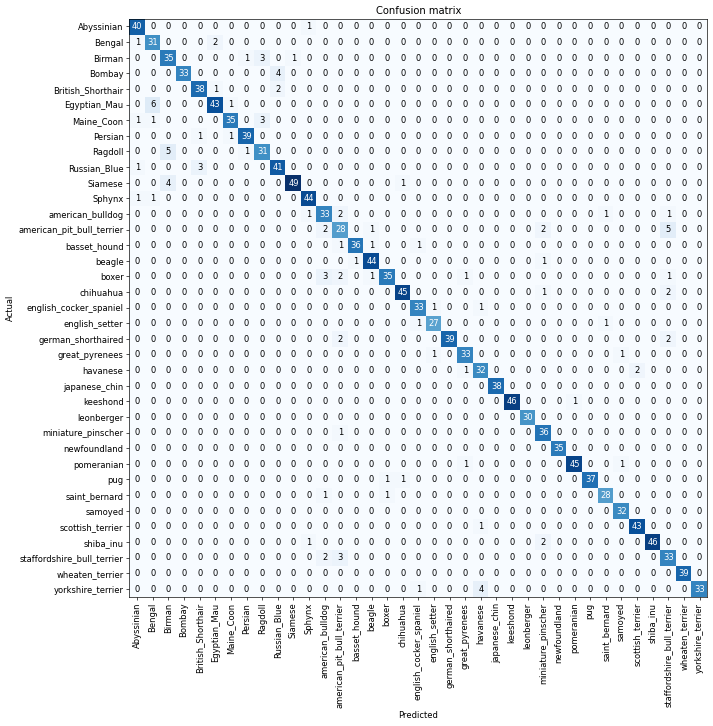

In [20]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [21]:
interp.most_confused(min_val=2)

[('Egyptian_Mau', 'Bengal', 6),
 ('Ragdoll', 'Birman', 5),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('Bombay', 'Russian_Blue', 4),
 ('Siamese', 'Birman', 4),
 ('yorkshire_terrier', 'havanese', 4),
 ('Birman', 'Ragdoll', 3),
 ('Maine_Coon', 'Ragdoll', 3),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('boxer', 'american_bulldog', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3),
 ('Bengal', 'Egyptian_Mau', 2),
 ('British_Shorthair', 'Russian_Blue', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2),
 ('american_pit_bull_terrier', 'american_bulldog', 2),
 ('american_pit_bull_terrier', 'miniature_pinscher', 2),
 ('boxer', 'american_pit_bull_terrier', 2),
 ('chihuahua', 'staffordshire_bull_terrier', 2),
 ('german_shorthaired', 'american_pit_bull_terrier', 2),
 ('german_shorthaired', 'staffordshire_bull_terrier', 2),
 ('havanese', 'scottish_terrier', 2),
 ('shiba_inu', 'miniature_pinscher', 2),
 ('staffordshire_bull_terrier', 'american_bulldo

## Unfreezing, fine-tuning


In the following we will unfreeze all the weights

In [29]:
learn2 = cnn_learner(data, models.resnet34, metrics=error_rate)
learn2.unfreeze()

When we train again the model we see how unfreezing some layers worsen the performance

In [30]:
learn2.fit(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.044827,1.807559,0.509472,01:28
1,1.349969,1.427569,0.407307,01:20
2,1.017516,1.297319,0.381597,01:21
3,0.810940,0.969791,0.279432,01:20


Now we compare with doing transfer learning, getting better performance in half the epochs

In [34]:
learn3 = cnn_learner(data, models.resnet34, metrics=error_rate)


In [35]:
learn3.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.484568,0.382167,0.121110,01:17


epoch,train_loss,valid_loss,error_rate,time
0,0.467926,0.312796,0.101489,01:20
1,0.243188,0.263017,0.084574,01:20


From 38% error rate without transfer learning to 8% using half the epochs
It 